In [1]:
import time
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC
import numpy as np
from sklearn import metrics
from model import DIN, DIEN, BaseModel,  LR
from prepare_data import *
from data_iterator import *
import os
import tensorflow as tf
import datetime
def setup_seed(seed):
    random.seed(seed) 
    np.random.seed(seed) 
    tf.random.set_seed(seed)  # tf cpu fix seed
    os.environ['TF_DETERMINISTIC_OPS'] = '1'  # tf gpu fix seed, please `pip install tensorflow-determinism` first
setup_seed(16)
# ========================= File Paths =======================
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/test/' + current_time + '/train'
summary_writer = tf.summary.create_file_writer(train_log_dir)
mode_save_path = "./saved_model"
# ========================= Training Setting =======================
func_span = 100   # How many iteration to call functions
global_best_auc = -1  # Keep to -1
global_patients = 0  # Keep to 0
epochs = 100
mode = 'normal' # 'normal', 'crossvalidation'
# ========================= Hyper Parameters =======================
maxlen = 100  #100
embed_dim = 16 # to make life easier all sparse features have same embedding dim 16
att_hidden_units = [160, 80, 40]  # FFN for Attention Layer
ffn_hidden_units = [256, 128, 64] # FFN for final output
dnn_dropout = 0.5 # Need to ensure this
att_activation = 'sigmoid'
ffn_activation = 'prelu' #prelu
train_batch_size = 128  # 128
test_val_batch_size = 2048
learning_rate = 0.001
l2_weight = 0.0001
weight_auxiliary = 0.1
# ========================== Create dataset =======================
feature_columns, train, dev, test = process_data(embed_dim, maxlen)
train_X, train_y = train
dev_X, dev_y = dev
test_X, test_y = test
dev_data_all = get_dataloader(test_val_batch_size, dev_X, dev_y)
test_data_all = get_dataloader(test_val_batch_size, test_X, test_y)
num_instance = len(train_X[0])

embedding size is 16, max sequence length is 100
Data is already, start training...
start !!!!!!
start !!!!!!


In [2]:
feature_columns, train, dev, test = process_data(embed_dim, maxlen)
train_X, train_y = train
dev_X, dev_y = dev
test_X, test_y = test
dev_data_all = get_dataloader(test_val_batch_size, dev_X, dev_y)
test_data_all = get_dataloader(test_val_batch_size, test_X, test_y)
num_instance = len(train_X[0])

embedding size is 16, max sequence length is 100
Data is already, start training...
start !!!!!!
start !!!!!!


In [3]:
DIN = DIN(feature_columns, att_hidden_units, ffn_hidden_units, att_activation,ffn_activation, maxlen, dnn_dropout)
DIEN = DIEN(feature_columns, att_hidden_units, ffn_hidden_units, att_activation,ffn_activation, maxlen, dnn_dropout,  embed_dim=embed_dim)
BaseModel = BaseModel(feature_columns, att_hidden_units, ffn_hidden_units, att_activation,ffn_activation, maxlen, dnn_dropout,  embed_dim=embed_dim)
LR = LR(feature_columns, att_hidden_units, ffn_hidden_units, att_activation,ffn_activation, maxlen, dnn_dropout,  embed_dim=embed_dim)

In [4]:
BaseModel.load_weights("./saved_weights/BaseModel/BaseModel_0.8693436574002537.ckpt")
DIN.load_weights("./saved_weights/DIN/DIN_0.8892130669036009.ckpt")
LR.load_weights("./saved_weights/LR/LR_0.8079523807697784.ckpt")
DIEN.load_weights("./saved_weights/DIEN/DIEN_0.8945942317932614.ckpt")

In [5]:
def get_results(test_data_all, model, is_dien=False, is_din=False):
    global global_best_auc
    outputs = []
    labels = []
    for step, (mini_batch, label) in enumerate(test_data_all, start=1):
        if is_dien:
            l1, l2 = [], []
            output, logits, auxiliary_loss = model(mini_batch, l1, l2)
        elif is_din:
            l1 = []
            output, logits = model(mini_batch, l1)
        else:
            output, logits = model(mini_batch)
        outputs.append(output)
        labels.append(label)
    prob = tf.concat(outputs, 0)[:, 0]
    true = tf.concat(labels, 0)[:, 0]
    fpr, tpr, thresholds = metrics.roc_curve(true, prob, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    return prob, true

def get_evaluation(prob, true):
    fpr, tpr, thresholds = metrics.roc_curve(true, prob, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    precisions, recalls, thresholds = metrics.precision_recall_curve(true, prob, pos_label=1)
    f1_scores = (2 * precisions * recalls) / (precisions + recalls)
    best_f1_score = np.max(f1_scores[np.isfinite(f1_scores)])
    best_f1_score_index = np.argmax(f1_scores[np.isfinite(f1_scores)])
    recall = recalls[best_f1_score_index]
    precision = precisions[best_f1_score_index]
    F1 = f1_scores[best_f1_score_index]
    return recall, precision, F1, auc

def print_scores(prob, true):
    recall, precision, F1, auc = get_evaluation(prob, true)
    print(f"Recall: {recall}, precision : {precision}, F1 : {F1}, AUC: {auc}")
    
def print_relapro(auc):
    base_auc = 0.8677
    res = ((auc- 0.5)/(base_auc - 0.5)) - 1
    print(res)

In [6]:
prob1, true1 = get_results(test_data_all, DIEN, is_dien=True)
prob2, true2 = get_results(test_data_all, DIN, is_din=True)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [7]:
a = load_data('./results/glob_list_din')
b = load_data('./results/glob_list_dien')

In [9]:
'''
com1 = []
for item in a.values():
    com1.append(item[1])
com2 = []
for item in b.values():
    com2.append(item[1])
com1
from scipy import stats
import numpy as np

stats.ttest_ind(c,d)
prob, true = get_results(test_data_all, BaseModel, is_dien=False)

print_scores(prob, true)
print_relapro(0.8938)
'''


'\ncom1 = []\nfor item in a.values():\n    com1.append(item[1])\ncom2 = []\nfor item in b.values():\n    com2.append(item[1])\ncom1\nfrom scipy import stats\nimport numpy as np\n\nstats.ttest_ind(c,d)\nprob, true = get_results(test_data_all, BaseModel, is_dien=False)\n\nprint_scores(prob, true)\nprint_relapro(0.8938)\n'

In [10]:
import matplotlib.pyplot as plt

In [11]:
def get_evaluation(prob, true):
    fpr, tpr, thresholds = metrics.roc_curve(true, prob, pos_label=1)
    return fpr, tpr

In [12]:
prob, true = get_results(test_data_all, LR, is_dien=False)
fpr0, tpr0 = get_evaluation(prob, true)
prob, true = get_results(test_data_all, BaseModel, is_dien=False)
fpr1, tpr1 = get_evaluation(prob, true)
prob, true = get_results(test_data_all, DIN, is_din=True)
fpr2, tpr2 = get_evaluation(prob, true)
prob, true = get_results(test_data_all, DIEN, is_dien=True)
fpr3, tpr3 = get_evaluation(prob, true)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



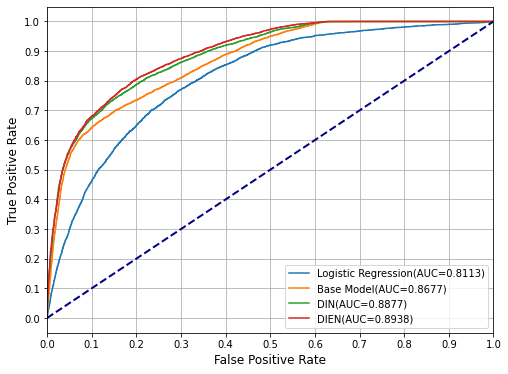

In [13]:
from matplotlib.pyplot import MultipleLocator
import datetime
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.locator_params('y', tight=True,nbins=14)
ax.plot(fpr0, tpr0,linestyle='-', label='Logistic Regression(AUC=0.8113)')
ax.plot(fpr1, tpr1,linestyle='-', label='Base Model(AUC=0.8677)')
ax.plot(fpr2, tpr2,linestyle='-', label='DIN(AUC=0.8877)')
ax.plot(fpr3, tpr3,linestyle='-', label='DIEN(AUC=0.8938)')
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax.legend()
x_major_locator=MultipleLocator(0.1)
#ax.set_ylim(760)
ax.xaxis.set_major_locator(x_major_locator,)
style = dict(size=13, color='black')
ax.margins(x=0.)
font1 = {'size'   : 12}
plt.ylabel("True Positive Rate", font1)
plt.xlabel('False Positive Rate', font1)
ax.grid()
plt.savefig('2.jpg', dpi=300, bbox_inches = 'tight')

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold, datasets
from util import *
def map_to_id(df, col_name):
    for col in col_name:
        key = sorted(df[col].unique().tolist())
        dict_ = dict(zip(key, range(1, len(key) + 1)))
        df.loc[:, col] = df[col].map(lambda x: dict_[x])

In [15]:
df = load_data(("./ddata/merged_DataFrame_fillna.pkl"))
col = ["item_sku_id", "item_third_cate_cd", "sex", 
       "action_type", "city", "user_level", 'province', 'county','brand_code', 'shop_id', 'vender_id']
map_to_id(df, col)

In [16]:
item_emb = DIN.embed_seq_layers[0].get_weights()[0]

In [17]:
buy = df.loc[df['action_type'] == 2].groupby("item_sku_id").count().sort_values('user_log_acct',ascending=False)
most = buy.index.tolist()[:250]
least = buy.index.tolist()[len(buy)-100250:-100000]
all_iid = most + least
all_type = []
for _ in range(len(most)):
    all_type.append(1)
for _ in range(len(least)):
    all_type.append(0)
target_emb = []
for i in range(len(all_iid)):
    target_emb.append(item_emb[all_iid[i]])
target_emb = np.array(target_emb)
len(buy)

137546

In [18]:
tsne = manifold.TSNE(n_components=2,  random_state=250, init='pca',learning_rate='auto', verbose=True)
X_tsne = tsne.fit_transform(target_emb)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.000s...
[t-SNE] Computed neighbors for 500 samples in 0.013s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 0.000000


D:\Anac\envs\ml\lib\site-packages\sklearn\manifold\_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.599300
[t-SNE] KL divergence after 1000 iterations: 0.721635


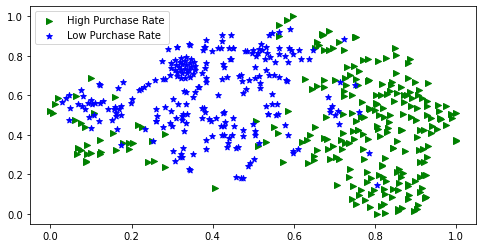

In [19]:
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)
plt.figure(figsize=(8, 4))
plt.scatter(X_norm[:250, 0], X_norm[:250, 1], c='g', label="High Purchase Rate", marker='>')
plt.scatter(X_norm[250:, 0], X_norm[250:, 1], c='b', label="Low Purchase Rate", marker='*')
plt.legend()
plt.savefig('2.jpg', dpi=300, bbox_inches = 'tight')
plt.show()


In [20]:
cate1 = df.loc[df["item_third_cate_cd"] == 20].sample(500)['item_sku_id'].tolist()
cate2 = df.loc[df["item_third_cate_cd"] == 30].sample(500)['item_sku_id'].tolist()
cate3 = df.loc[df["item_third_cate_cd"] == 40].sample(500)['item_sku_id'].tolist()
cate4 = df.loc[df["item_third_cate_cd"] == 50].sample(500)['item_sku_id'].tolist()
cate5 = df.loc[df["item_third_cate_cd"] == 60].sample(500)['item_sku_id'].tolist()

In [21]:
iid_list = df["item_sku_id"].tolist()
cat_list = df["item_third_cate_cd"].tolist()
iid_to_cat = {}
for i in range(len(iid_list)):
    iid_to_cat[iid_list[i]] = cat_list[i]

all_iid = cate1 + cate2 + cate3 + cate4 + cate5

all_cat = []
for i in range(len(all_iid)):
    all_cat.append(iid_to_cat[all_iid[i]])

target_emb = []
for i in range(len(all_iid)):
    target_emb.append(item_emb[all_iid[i]])
target_emb = np.array(target_emb)
tsne = manifold.TSNE(n_components=2,  random_state=501, init='pca',learning_rate='auto', verbose=True)
X_tsne = tsne.fit_transform(target_emb)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2500 samples in 0.001s...
[t-SNE] Computed neighbors for 2500 samples in 0.134s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2500
[t-SNE] Computed conditional probabilities for sample 2000 / 2500
[t-SNE] Computed conditional probabilities for sample 2500 / 2500
[t-SNE] Mean sigma: 0.000000


D:\Anac\envs\ml\lib\site-packages\sklearn\manifold\_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.365364
[t-SNE] KL divergence after 1000 iterations: 0.215489


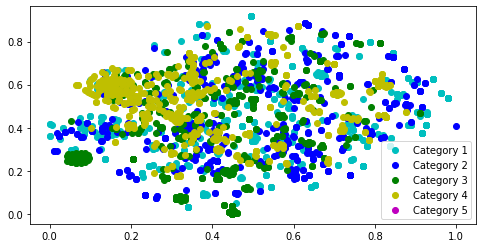

In [22]:
colors = ['c', 'b', 'g', 'y', 'm']
labels = ['Category 1', 'Category 2', 'Category 3', 'Category 4', 'Category 5']
    
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)  # 归一化
plt.figure(figsize=(8, 4))

plt.scatter(X_norm[:500, 0], X_norm[:500, 1], c=colors[0], label=labels[0])
plt.scatter(X_norm[500:1000, 0], X_norm[500:1000, 1], c=colors[1], label=labels[1])
plt.scatter(X_norm[1000:1500, 0], X_norm[1000:1500, 1], c=colors[2], label=labels[2])
plt.scatter(X_norm[1500:2000, 0], X_norm[1500:2000, 1], c=colors[3], label=labels[3])
plt.scatter(X_norm[2500:3000, 0], X_norm[2500:3000, 1], c=colors[4], label=labels[4])
plt.legend()
plt.savefig('2.jpg', dpi=300, bbox_inches = 'tight')
plt.show()

In [23]:
ordered = df.groupby('item_third_cate_cd').count().sort_values('user_log_acct', ascending=False)
cats = df['item_third_cate_cd'].tolist()
pop_list = [8, 35, 28, 82, 76]
mask = []
for ca in cats:
    if ca in pop_list:
        mask.append(True)
    else:
        mask.append(False)

In [24]:
df_filtered = df[mask]
all_iid = []
for ca in pop_list:
    temp = df_filtered.loc[df_filtered['item_third_cate_cd'] == ca].groupby('item_sku_id').count().sort_values('user_log_acct', ascending=False).index.tolist()[:500]
    all_iid += temp

In [25]:


iid_list = df["item_sku_id"].tolist()
cat_list = df["item_third_cate_cd"].tolist()
iid_to_cat = {}
for i in range(len(iid_list)):
    iid_to_cat[iid_list[i]] = cat_list[i]

all_cat = []
for i in range(len(all_iid)):
    all_cat.append(iid_to_cat[all_iid[i]])

target_emb = []
for i in range(len(all_iid)):
    target_emb.append(item_emb[all_iid[i]])
target_emb = np.array(target_emb)
tsne = manifold.TSNE(n_components=2,  random_state=501, init='pca',learning_rate='auto', verbose=True)
X_tsne = tsne.fit_transform(target_emb)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2500 samples in 0.000s...
[t-SNE] Computed neighbors for 2500 samples in 0.153s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2500
[t-SNE] Computed conditional probabilities for sample 2000 / 2500
[t-SNE] Computed conditional probabilities for sample 2500 / 2500
[t-SNE] Mean sigma: 0.021307


D:\Anac\envs\ml\lib\site-packages\sklearn\manifold\_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.306168
[t-SNE] KL divergence after 1000 iterations: 1.656626


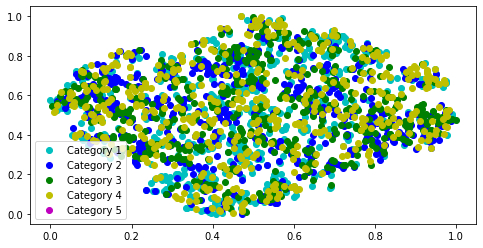

In [26]:
colors = ['c', 'b', 'g', 'y', 'm']
labels = ['Category 1', 'Category 2', 'Category 3', 'Category 4', 'Category 5']
    
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)  # 归一化
plt.figure(figsize=(8, 4))

plt.scatter(X_norm[:500, 0], X_norm[:500, 1], c=colors[0], label=labels[0])
plt.scatter(X_norm[500:1000, 0], X_norm[500:1000, 1], c=colors[1], label=labels[1])
plt.scatter(X_norm[1000:1500, 0], X_norm[1000:1500, 1], c=colors[2], label=labels[2])
plt.scatter(X_norm[1500:2000, 0], X_norm[1500:2000, 1], c=colors[3], label=labels[3])
plt.scatter(X_norm[2500:3000, 0], X_norm[2500:3000, 1], c=colors[4], label=labels[4])

plt.legend()
plt.savefig('2.jpg', dpi=300, bbox_inches = 'tight')
plt.show()

In [27]:
# ##########################################

In [28]:
df = load_data('./ddata/start_data/df_final.pkl')

In [29]:
df = pd.concat(df[1:])
item_emb = DIN.embed_seq_layers[0].get_weights()[0]

In [30]:
buy = df.groupby("item_sku_id").count().sort_values('user_log_acct',ascending=False)
most = buy.index.tolist()[:250]
ll = 60000 #60000
least = buy.index.tolist()[len(buy)-ll:-ll + 250]
all_iid = most + least
all_type = []
for _ in range(len(most)):
    all_type.append(1)
for _ in range(len(least)):
    all_type.append(0)
target_emb = []
for i in range(len(all_iid)):
    target_emb.append(item_emb[all_iid[i]])
target_emb = np.array(target_emb)
print(len(buy))
tsne = manifold.TSNE(n_components=2,  random_state=250, init='pca',learning_rate='auto', verbose=True)
X_tsne = tsne.fit_transform(target_emb)


94566
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.000s...
[t-SNE] Computed neighbors for 500 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 0.013807


D:\Anac\envs\ml\lib\site-packages\sklearn\manifold\_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.706558
[t-SNE] KL divergence after 1000 iterations: 0.788467


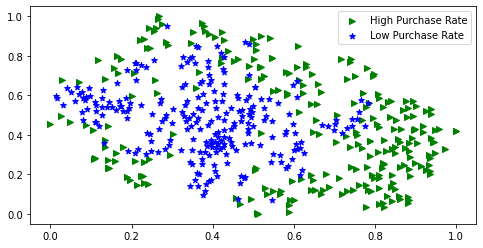

In [31]:
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)
plt.figure(figsize=(8, 4))
plt.scatter(X_norm[:250, 0], X_norm[:250, 1], c='g', label="High Purchase Rate", marker='>')
plt.scatter(X_norm[250:, 0], X_norm[250:, 1], c='b', label="Low Purchase Rate", marker='*')
plt.legend()
plt.savefig('2.jpg', dpi=300, bbox_inches = 'tight')
plt.show()

20262
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.001s...
[t-SNE] Computed neighbors for 500 samples in 0.013s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 0.004823


D:\Anac\envs\ml\lib\site-packages\sklearn\manifold\_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 100 iterations with early exaggeration: 58.832859
[t-SNE] KL divergence after 1000 iterations: 0.877944


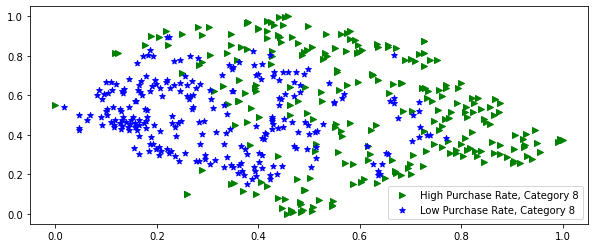

In [32]:
df_cat8 = df.loc[df["item_third_cate_cd"] == 8]
buy = df_cat8.groupby("item_sku_id").count().sort_values('user_log_acct',ascending=False)
most = buy.index.tolist()[:250]
ll = 251 #50000
least = buy.index.tolist()[len(buy)-ll:-ll + 250]
all_iid = most + least
all_type = []
for _ in range(len(most)):
    all_type.append(1)
for _ in range(len(least)):
    all_type.append(0)
target_emb = []
for i in range(len(all_iid)):
    target_emb.append(item_emb[all_iid[i]])
target_emb = np.array(target_emb)
print(len(buy))
tsne = manifold.TSNE(n_components=2,  random_state=250, init='pca',learning_rate='auto', verbose=True)
X_tsne = tsne.fit_transform(target_emb)
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)
plt.figure(figsize=(10, 4))
plt.scatter(X_norm[:250, 0], X_norm[:250, 1], c='g', label="High Purchase Rate, Category 8", marker='>')
plt.scatter(X_norm[250:, 0], X_norm[250:, 1], c='b', label="Low Purchase Rate, Category 8", marker='*')
plt.legend()
plt.savefig('2.jpg', dpi=300, bbox_inches = 'tight')
plt.show()

In [33]:
len(least)

250

In [34]:
#  #############################

In [35]:
import time
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC
import numpy as np
from sklearn import metrics
from model import DIN, DIEN, BaseModel,  LR
from prepare_data import *
from data_iterator import *
import os
import tensorflow as tf
import datetime
def setup_seed(seed):
    random.seed(seed)  # 为python设置随机种子
    np.random.seed(seed)  # 为numpy设置随机种子
    tf.random.set_seed(seed)  # tf cpu fix seed
    os.environ['TF_DETERMINISTIC_OPS'] = '1'  # tf gpu fix seed, please `pip install tensorflow-determinism` first
setup_seed(16)
maxlen = 100  #100
embed_dim = 16 # to make life easier all sparse features have same embedding dim 16
att_hidden_units = [160, 80, 40]  # FFN for Attention Layer
ffn_hidden_units = [256, 128, 64] # FFN for final output
dnn_dropout = 0.5 # Need to ensure this
att_activation = 'sigmoid'
ffn_activation = 'prelu' #prelu
train_batch_size = 128  # 128
test_val_batch_size = 2048
learning_rate = 0.001
l2_weight = 0.0001
weight_auxiliary = 0.1

In [36]:
feature_columns = load_data("./ddata/process_feature_columns.pkl")
train_X = load_data("./ddata/process_train_X.pkl")
train_y = load_data("./ddata/process_train_y.pkl")
dev_X = load_data("./ddata/process_dev_X.pkl")
dev_y = load_data("./ddata/process_dev_y.pkl")
test_X = load_data("./ddata/process_test_X.pkl")
test_y = load_data("./ddata/process_test_y.pkl")

In [37]:
DIN = DIN(feature_columns, att_hidden_units, ffn_hidden_units, att_activation,ffn_activation, maxlen, dnn_dropout)
DIEN = DIEN(feature_columns, att_hidden_units, ffn_hidden_units, att_activation,ffn_activation, maxlen, dnn_dropout,  embed_dim=embed_dim)
BaseModel = BaseModel(feature_columns, att_hidden_units, ffn_hidden_units, att_activation,ffn_activation, maxlen, dnn_dropout,  embed_dim=embed_dim)
LR = LR(feature_columns, att_hidden_units, ffn_hidden_units, att_activation,ffn_activation, maxlen, dnn_dropout,  embed_dim=embed_dim)
BaseModel.load_weights("./saved_weights/BaseModel/BaseModel_0.8693436574002537.ckpt")
DIN.load_weights("./saved_weights/DIN/DIN_0.8892130669036009.ckpt")
LR.load_weights("./saved_weights/LR/LR_0.8079523807697784.ckpt")
DIEN.load_weights("./saved_weights/DIEN/DIEN_0.8945942317932614.ckpt")

In [38]:
df = load_data("./ddata/start_data/df_final.pkl")
df_data = pd.concat(df[1:])

In [39]:
df_data.groupby("item_sku_id").count().sort_values("sex", ascending=False).head(10)

,user_log_acct,month_day,label,user_item,sex,city,user_level,province,county,item_third_cate_cd,...,item_seq,cate_seq,type_seq,user_log_acct_last30_days_action_1,user_log_acct_last30_days_action_2,user_log_acct_last30_days_action_3,user_log_acct_last30_days_action_4,user_log_acct_last30_days_action_1_rt,user_log_acct_last30_days_action_3_rt,user_log_acct_last30_days_action_4_rt
item_sku_id,,,,,,,,,,,,,,,,,,,,,
258625,2541,2541,2541,2541,2541,2541,2541,2541,2541,2541,...,2541,2541,2541,2541,2541,2541,2541,2541,2541,2541
224207,2183,2183,2183,2183,2183,2183,2183,2183,2183,2183,...,2183,2183,2183,2183,2183,2183,2183,2183,2183,2183
152092,1084,1084,1084,1084,1084,1084,1084,1084,1084,1084,...,1084,1084,1084,1084,1084,1084,1084,1084,1084,1084
248051,988,988,988,988,988,988,988,988,988,988,...,988,988,988,988,988,988,988,988,988,988
19643,932,932,932,932,932,932,932,932,932,932,...,932,932,932,932,932,932,932,932,932,932
107331,747,747,747,747,747,747,747,747,747,747,...,747,747,747,747,747,747,747,747,747,747
58826,701,701,701,701,701,701,701,701,701,701,...,701,701,701,701,701,701,701,701,701,701
37284,690,690,690,690,690,690,690,690,690,690,...,690,690,690,690,690,690,690,690,690,690
141479,642,642,642,642,642,642,642,642,642,642,...,642,642,642,642,642,642,642,642,642,642


In [40]:
df_data.loc[df_data["item_sku_id"] == 152092].item_third_cate_cd

20       70
204      70
476      70
769      70
866      70
         ..
48640    70
48830    70
49934    70
50468    70
50782    70
Name: item_third_cate_cd, Length: 1084, dtype: int64

In [41]:
# 2 hist 4 target

In [42]:
index = 4
sample = [np.array([train_X[0][index]]), np.array([train_X[1][index]]), np.array([train_X[2][index]]), np.array([train_X[3][index]]), np.array([train_X[4][index]]), np.array([train_X[5][index]])]

In [43]:
sample

[array([[0.]]),
 array([[242,   3,   5,  16, 417]]),
 array([[[     0,      0,      0],
         [     0,      0,      0],
         [     0,      0,      0],
         [     0,      0,      0],
         [     0,      0,      0],
         [     0,      0,      0],
         [     0,      0,      0],
         [     0,      0,      0],
         [     0,      0,      0],
         [     0,      0,      0],
         [     0,      0,      0],
         [     0,      0,      0],
         [     0,      0,      0],
         [     0,      0,      0],
         [     0,      0,      0],
         [     0,      0,      0],
         [     0,      0,      0],
         [     0,      0,      0],
         [179231,     65,      1],
         [103709,     74,      1],
         [103709,     74,      1],
         [288728,     74,      1],
         [233783,     42,      1],
         [199998,     42,      1],
         [199998,     42,      3],
         [168302,     42,      1],
         [233783,     42,      3],
  

In [44]:
sample[4][0] = np.array([258625, 8, 2])

In [45]:
sample[2][0][-6] = np.array([258625, 8, 2]) # 同 购买 1
sample[2][0][-5] = np.array([258625, 8, 1]) # 同 非购买 6   
sample[2][0][-4] = np.array([37284, 76, 2]) # 不同 不同类 购买 3 [37284, 76, 2]  [152092, 70, 2]
sample[2][0][-3] = np.array([37284, 76, 1]) # 不同 不同类 非购买 2
sample[2][0][-2] = np.array([224207, 8, 2]) # 不同 同类 购买 4
sample[2][0][-1] = np.array([224207, 8, 1]) # 不同 同类 非购买 5

In [46]:
att_score = []
res = DIN(sample,att_score)
behaviors = np.array(att_score[0][0][-6:])  
behaviors

#[0.44870612, 0.4486302 , 0.44870237, 0.44862646, 0.44870654,
#       0.44863057]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



array([0.44870612, 0.4486302 , 0.44870314, 0.44862732, 0.44870654,
       0.44863057], dtype=float32)

In [47]:
mi = min(behaviors)
ma = max(behaviors)
nor_res = (behaviors - mi)/ (ma - mi) + 0.1

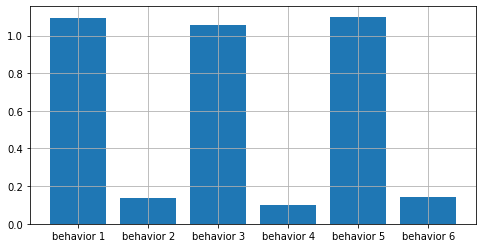

In [48]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
labels = ['behavior 1', 'behavior 2', 'behavior 3', 'behavior 4', 'behavior 5', 'behavior 6']
plt.grid()
plt.bar(range(len(nor_res)), nor_res, tick_label=labels)
plt.savefig('2.jpg', dpi=300, bbox_inches = 'tight')
plt.show()



In [49]:
behaviors

array([0.44870612, 0.4486302 , 0.44870314, 0.44862732, 0.44870654,
       0.44863057], dtype=float32)

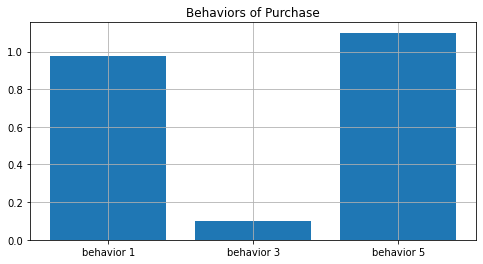

In [50]:
import matplotlib.pyplot as plt
buys_ = behaviors[[0,2,4]]
mi = min(buys_)
ma = max(buys_)
nor_res = (buys_ - mi)/ (ma - mi) + 0.1

plt.figure(figsize=(8, 4))
labels = ['behavior 1', 'behavior 3', 'behavior 5']
plt.grid()
plt.bar(range(3), nor_res, tick_label=labels)
plt.title("Behaviors of Purchase")
plt.savefig('2.jpg', dpi=300, bbox_inches = 'tight')
plt.show()

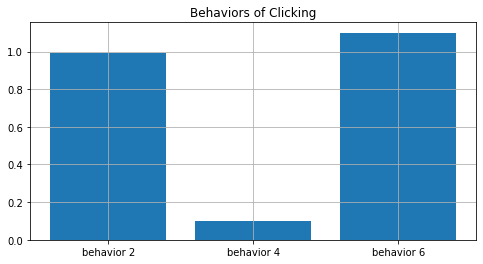

In [51]:
import matplotlib.pyplot as plt
clicks = behaviors[[1,3,5]]
mi = min(clicks)
ma = max(clicks)
nor_res = (clicks - mi)/ (ma - mi) + 0.1
plt.figure(figsize=(8, 4))
labels = ['behavior 2', 'behavior 4', 'behavior 6']
plt.grid()
plt.bar(range(3), nor_res, tick_label=labels)
plt.title("Behaviors of Clicking")
plt.savefig('2.jpg', dpi=300, bbox_inches = 'tight')
plt.show()

In [52]:
#  #############################

In [53]:
index = 28
sample = [np.array([train_X[0][index]]), np.array([train_X[1][index]]), np.array([train_X[2][index]]), np.array([train_X[3][index]]), np.array([train_X[4][index]]), np.array([train_X[5][index]])]
sample[4][0] = np.array([258625, 8, 2])
sample[2][0][-12] = np.array([258625, 8, 1]) # 同 购买 1
sample[2][0][-11] = np.array([37284, 76, 1]) # 同 非购买 6
sample[2][0][-10] = np.array([258625, 76, 1]) # 不同 不同类 购买 3
sample[2][0][-9] = np.array([37284, 76, 1]) # 不同 不同类 非购买 2
sample[2][0][-8] = np.array([37284, 76, 1]) # 不同 同类 购买 4
sample[2][0][-7] = np.array([224207, 8, 1]) # 不同 同类 非购买 5
sample[2][0][-6] = np.array([37284, 76, 1]) # 同 购买 1
sample[2][0][-5] = np.array([37284, 76, 1]) # 同 非购买 6
sample[2][0][-4] = np.array([224207, 8, 1]) # 不同 不同类 购买 3
sample[2][0][-3] = np.array([37284, 76, 1]) # 不同 不同类 非购买 2
sample[2][0][-2] = np.array([258625, 76, 1]) # 不同 同类 购买 4
sample[2][0][-1] = np.array([37284, 76, 1]) # 不同 同类 非购买 5


In [54]:
hidden, att = [], []
res = DIEN(sample, hidden, att)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [55]:
hiddens = []
for item in hidden:
    hiddens.append(np.array(item))
hiddens = np.array(hiddens)
hiddens = hiddens.reshape(100, 48)
hiddens = hiddens[-12:]

In [56]:
################################

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import manifold, datasets
from util import *
from sklearn.decomposition import PCA
tsne = sklearn.decomposition.PCA(n_components=2)
X_tsne = tsne.fit_transform(hiddens)


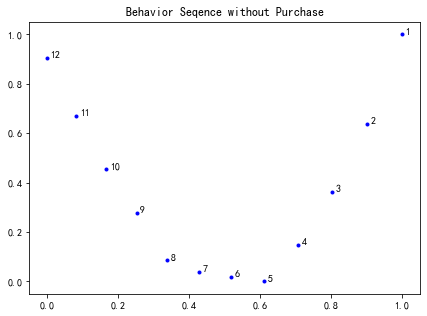

In [58]:
txt = ['1','2','3','4','5','6','7','8','9', '10', '11', '12']
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)
plt.figure(figsize=(7, 5))
plt.rcParams['font.sans-serif']=['SimHei']
plt.scatter(X_norm[:8,0], X_norm[:8, 1], c='b', marker='.')
plt.scatter(X_norm[9:,0], X_norm[9:, 1], c='b', marker='.')
plt.scatter(X_norm[8][0], X_norm[8][1], c='b',  marker='.')
for i in range(len(X_norm)):
    plt.annotate(txt[i], xy = (X_norm[i][0], X_norm[i][1]), xytext = (X_norm[i][0] + 0.01, X_norm[i][1])) 
#plt.legend()
plt.title("Behavior Seqence without Purchase")
plt.savefig('2.jpg', dpi=300, bbox_inches = 'tight')
plt.show()






In [59]:
lr = np.array(load_data("./results/glob_list_lr"))
base = np.array(load_data("./results/glob_list_base"))
din = np.array(load_data("./results/glob_list_din"))
dien = np.array(load_data("./results/glob_list_dien"))

In [60]:
means = []
stds = []
for item in [lr, base, din, dien]:
    means.append(np.mean(item))
    stds.append(np.std(item))


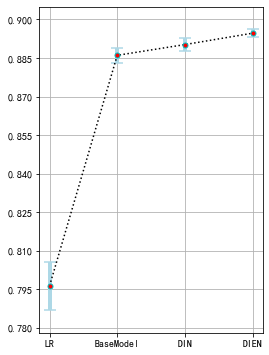

In [61]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(4, 6))
x = [0, 1, 2, 3]
y = means

lower = []
upper = []
error_limit = []
for item in [lr, base, din, dien]:
    lower.append(np.mean(item) - np.min(item))
    upper.append(np.max(item) - np.mean(item))
error_limit.append(lower)
error_limit.append(upper)    
plt.errorbar(x, y, yerr=stds, fmt=":o", color='black',ecolor="lightblue", elinewidth=4,
             ms=5, mfc="r", mec="c", capsize=6, capthick=1.5)
plt.ylim(0.778, 0.905)
my_x_ticks = np.arange(0, 4, 1)
my_y_ticks = np.arange(0.78, 0.905, 0.015)
index_ls = ['LR','BaseModel','DIN','DIEN']
plt.xticks(my_x_ticks, index_ls)
plt.yticks(my_y_ticks)
plt.savefig('2.jpg', dpi=300, bbox_inches = 'tight')
plt.grid()
plt.show()

In [62]:
from util import *
import matplotlib.pyplot as plt
import numpy as np

In [63]:
train_au = np.array(load_data("./results/auxiliary_train"))
val_au = np.array(load_data("./results/auxiliary_val"))
train_ba = np.array(load_data("./results/base_train"))
val_ba = np.array(load_data("./results/base_val"))
x = []
for i in range(len(val_ba)):
    x.append((i + 1) * 100)

In [64]:
val_au *= 1.5
train_au *= 1.5

In [65]:
i = 8
train_au = train_au[:i]
val_au = val_au[:i]
train_ba = train_ba[:i]
val_ba = val_ba[:i]
x = x[:i]

D:\Anac\envs\ml\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
D:\Anac\envs\ml\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


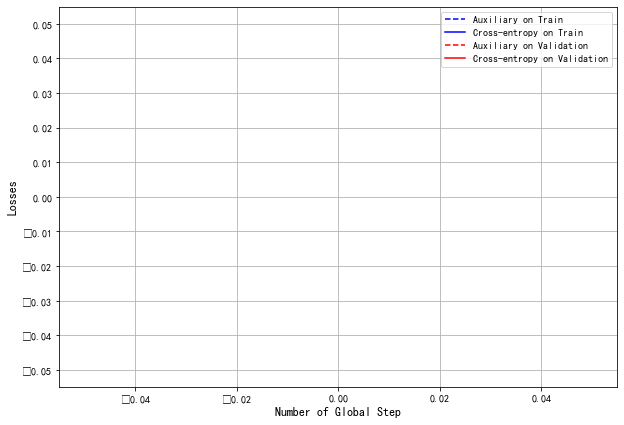

In [66]:
from matplotlib.pyplot import MultipleLocator
import datetime
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
ax.locator_params('y', tight=True,nbins=14)
ax.plot(x, train_au,linestyle='--', color='b', label="Auxiliary on Train")
ax.plot(x, train_ba,linestyle='-', color='b', label="Cross-entropy on Train")
ax.plot(x, val_au,linestyle='--', color='r', label="Auxiliary on Validation")
ax.plot(x, val_ba,linestyle='-', color='r', label="Cross-entropy on Validation")
ax.legend()
#x_major_locator=MultipleLocator(1)
#ax.set_ylim(760)
#ax.xaxis.set_major_locator(x_major_locator,)
style = dict(size=13, color='black')
#ax.margins(x=0.02)
font1 = {'size'   : 12}
plt.ylabel("Losses", font1)
plt.xlabel('Number of Global Step', font1)
ax.grid()
plt.savefig('2.jpg', dpi=300, bbox_inches = 'tight')
plt.show()


D:\Anac\envs\ml\lib\site-packages\statsmodels\stats\stattools.py:75: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  "samples were given." % int(n), ValueWarning)
